In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 载入数据

In [10]:
raw_data = pd.read_csv('./train.csv')

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
raw_data.describe([0.75, 0.9])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
90%,802.000000,1.000000,3.000000,50.000000,1.000000,2.000000,77.958300
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 数据总览

In [9]:
# 利用pandas_profiling库，观察下数据总览
import pandas_profiling
report = pandas_profiling.ProfileReport(raw_data)
report.to_file('./eda.html')

1. label为Survived, 0和1的比例为549：342，还算平衡
2. 数值类型数据包括：Age（年龄）、Fare（费用）、Parch（直系亲属数量）、PassengerId（ID）、SibSp（姐妹数量）
3. 离散类型数据包括：Embarked（登船港口，分为S、C、Q），Pclass（船舱等级，分为1、2、3）、Sex（性别，分为male和female）
4. 文本类型数据包括：Cabin（舱位号）、Name（名字）、Ticket（船票号）
5. 缺失数据有：Embarked（缺2），Age（缺失177例），Cabin（缺失687例）

#### Survived

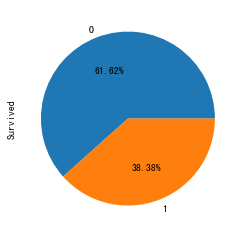

In [5]:
raw_data['Survived'].value_counts().plot(kind='pie', labeldistance=1.1, autopct='%1.2f%%')

#### Age

存活or死亡人员中，年龄分布大致相同。但注意到在低龄儿童上，存活率显著高于死亡率。这可能会成为一种bins方案

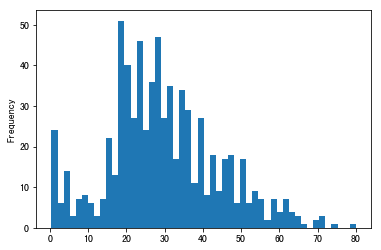

In [6]:
raw_data['Age'].plot(kind='hist', bins=50)

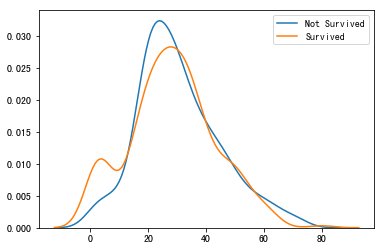

In [11]:
sns.kdeplot(raw_data[raw_data['Survived']==0]['Age'], label='Not Survived')
sns.kdeplot(raw_data[raw_data['Survived']==1]['Age'], label='Survived')
plt.show()

In [221]:
raw_data_age = raw_data[['Age', 'Survived']]
raw_data_age.dropna(axis=0, inplace=True)
raw_data_age['Age_int'] = raw_data_age['Age'].apply(int)
raw_data_age_detail = raw_data_age[['Age_int', 'Survived']].groupby('Age_int', as_index=False).mean()
raw_data_age_detail.head()

,Age_int,Survived
0,0,1.000000
1,1,0.714286
2,2,0.300000
3,3,0.833333
4,4,0.700000


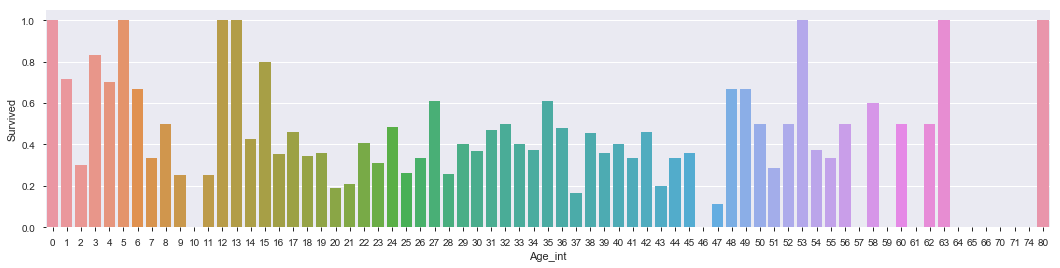

In [222]:
fig, ax = plt.subplots(figsize=(18, 4))
sns.barplot(x='Age_int', y='Survived', data=raw_data_age_detail)

#### PassengerId

PassengerId仅仅为一个顺序编号，并无意义，可剔除。

In [15]:
raw_data['PassengerId'].min()

1

In [16]:
raw_data['PassengerId'].max()

891

#### Pclass

显然，船舱等级越高的旅客越少，但其存活率越高。这是一个重要因子。

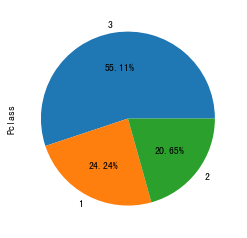

In [19]:
raw_data['Pclass'].value_counts().plot(kind='pie',labeldistance=1.1, autopct='%1.2f%%')

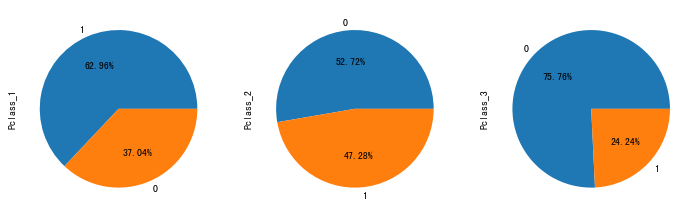

In [49]:
fig = plt.figure(figsize=(12, 8))
ax1, ax2, ax3 = fig.subplots(1, 3)
raw_data[raw_data['Pclass']==1]['Survived'].value_counts().plot(ax=ax1, kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='Pclass_1')
raw_data[raw_data['Pclass']==2]['Survived'].value_counts().plot(ax=ax2, kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='Pclass_2')
raw_data[raw_data['Pclass']==3]['Survived'].value_counts().plot(ax=ax3, kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='Pclass_3')
plt.show()

#### Sex

女性的存活率高于男性

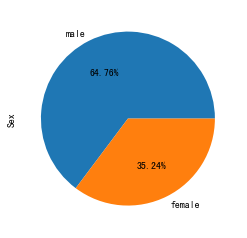

In [52]:
raw_data['Sex'].value_counts().plot(kind='pie', autopct='%1.2f%%', label='Sex')

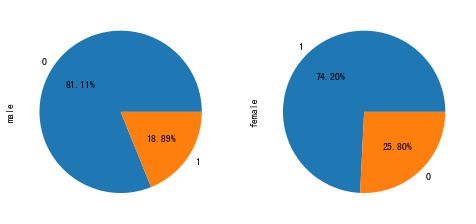

In [54]:
# 不同年龄里的存活情况，女性的生存概率略高于男性
fig = plt.figure(figsize=(8, 6))
ax1, ax2 = fig.subplots(1, 2)
raw_data[raw_data['Sex']=='male']['Survived'].value_counts().plot(ax=ax1, kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='male')
raw_data[raw_data['Sex']=='female']['Survived'].value_counts().plot(ax=ax2, kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='female')

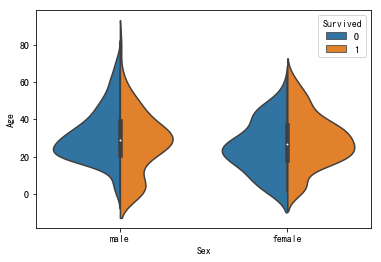

In [57]:
# 不同性别和年龄组合下的生存情况
# 无论对于男性，还是女性。存活/死亡人群中的年龄分布大致对称。但仍可以注意到：（1）男性低龄的存活率很高；（2）女性高龄的存活率很高，这按时可以将年龄bins
sns.violinplot(x='Sex', y='Age', hue='Survived', split=True, data=raw_data)

#### Embarked

共有S、C、Q三个港口，比例严重不均衡。C港口的存活率明显高于其它港口。

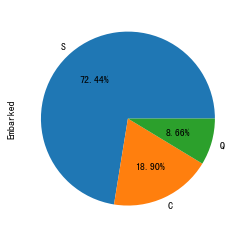

In [58]:
raw_data['Embarked'].value_counts().plot(kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='Embarked')

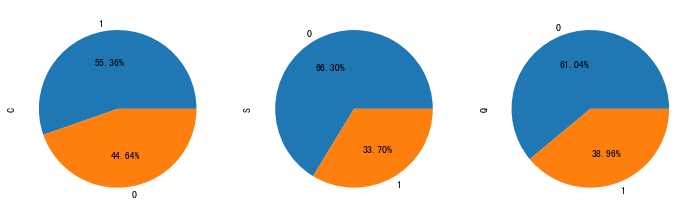

In [59]:
fig = plt.figure(figsize=(12, 8))
ax1, ax2, ax3 = fig.subplots(1, 3)
raw_data[raw_data['Embarked']=='C']['Survived'].value_counts().plot(ax=ax1, kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='C')
raw_data[raw_data['Embarked']=='S']['Survived'].value_counts().plot(ax=ax2, kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='S')
raw_data[raw_data['Embarked']=='Q']['Survived'].value_counts().plot(ax=ax3, kind='pie',labeldistance=1.1, autopct='%1.2f%%', label='Q')
plt.show()

#### Fare

Fare的分布极其不均匀，最高达500+， 最低为0，不符合常识.
怀疑是否是一家人的票计在某个人头上，但通过举例分析，发现并没与这个情况。
Fare和Pclass之间有一定的关系，但并不明显。即Pclass中也有很低的Fare。
Fare和Survived之间的相关性暂未发现，但值得注意的是，对于Fare>500的旅客，其存活率为100%

In [71]:
raw_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

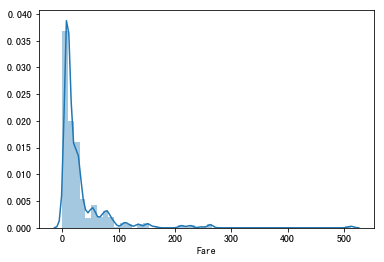

In [6]:
sns.distplot(raw_data['Fare'])

In [11]:
raw_data[raw_data['Fare']==raw_data['Fare'].max()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [15]:
raw_data.iloc[679]['Cabin']

'B51 B53 B55'

In [16]:
raw_data[raw_data['Cabin']=='B51 B53 B55']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S


In [17]:
raw_data[raw_data['Fare']==raw_data['Fare'].min()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [29]:
import re
reg = re.compile(r'Thomas')
raw_data[raw_data['Name'].apply(lambda x: True if reg.findall(x) else False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.00,0,0,244310,13.0000,NaN,S
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.00,1,0,113776,66.6000,C2,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
186,187,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q
252,253,0,1,"Stead, Mr. William Thomas",male,62.00,0,0,113514,26.5500,C87,S
260,261,0,3,"Smith, Mr. Thomas",male,NaN,0,0,384461,7.7500,NaN,Q
336,337,0,1,"Pears, Mr. Thomas Clinton",male,29.00,1,0,113776,66.6000,C2,S
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S
364,365,0,3,"O'Brien, Mr. Thomas",male,NaN,1,0,370365,15.5000,NaN,Q
372,373,0,3,"Beavan, Mr. William Thomas",male,19.00,0,0,323951,8.0500,NaN,S


观察不同船舱等级和费用间的联系

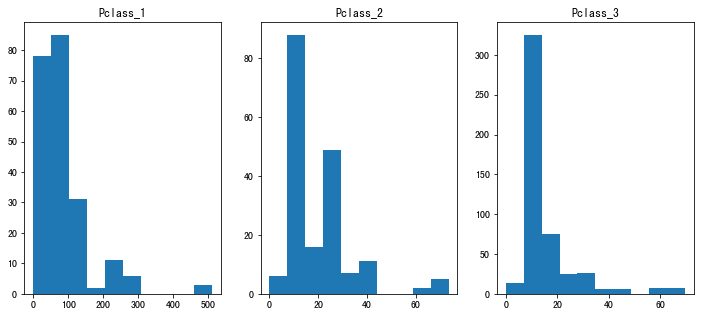

In [33]:
fig = plt.figure(figsize=(12, 5))
ax1, ax2, ax3 = fig.subplots(1, 3)
ax1.hist(raw_data[raw_data['Pclass']==1]['Fare'])
ax1.set_title('Pclass_1')
ax2.hist(raw_data[raw_data['Pclass']==2]['Fare'], label='Pclass_2')
ax2.set_title('Pclass_2')
ax3.hist(raw_data[raw_data['Pclass']==3]['Fare'], label='Pclass_3')
ax3.set_title('Pclass_3')
plt.show()

观察存活和死亡乘客的票价分布

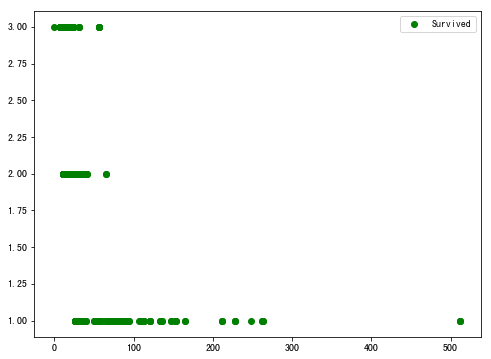

In [43]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(raw_data[raw_data['Survived']==1]['Fare'], raw_data[raw_data['Survived']==1]['Pclass'],c='green', label='Survived')
# plt.legend([p1, p2], ['Survived', 'Not Survived'])
plt.legend()
plt.show()

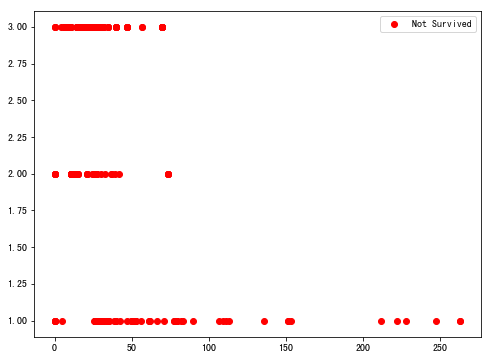

In [45]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(raw_data[raw_data['Survived']==0]['Fare'], raw_data[raw_data['Survived']==0]['Pclass'],c='red', label='Not Survived')
# plt.legend([p1, p2], ['Survived', 'Not Survived'])
plt.legend()
plt.show()

各Pclass的价格均值，有明显差别。

In [94]:
raw_data[raw_data['Pclass']==1]['Fare'].describe()

count    216.000000
mean      84.154687
std       78.380373
min        0.000000
25%       30.923950
50%       60.287500
75%       93.500000
max      512.329200
Name: Fare, dtype: float64

In [95]:
raw_data[raw_data['Pclass']==2]['Fare'].describe()

count    184.000000
mean      20.662183
std       13.417399
min        0.000000
25%       13.000000
50%       14.250000
75%       26.000000
max       73.500000
Name: Fare, dtype: float64

In [96]:
raw_data[raw_data['Pclass']==3]['Fare'].describe()

count    491.000000
mean      13.675550
std       11.778142
min        0.000000
25%        7.750000
50%        8.050000
75%       15.500000
max       69.550000
Name: Fare, dtype: float64

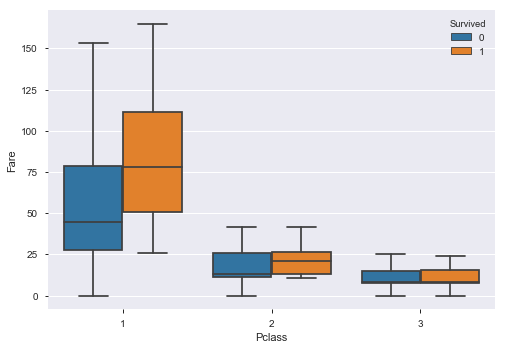

In [224]:
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=raw_data, showfliers=False)

#### Cabin

cabin有很严重的缺失值(77.1%)，且分布很凌乱
<br>多以A、B、C开头，应该为位置号
<br>通过对比发现，部分乘客有很长的cabin号，验证发现这表明这些乘客可能为别人代买了票（其cabin和fare均记在该人名下，且所买的区段基本都一样），从而导致了Fare特征的分布异常以及Cabin特征的大量缺失量
<br> 整个Fare的缺失值很大，所以分析只能建立在非缺失的少量样本上
<br> Cabin值非空乘客中，各舱的生存率均几乎均大于50%（最大可达到近70%），这与总体的存活率有明显差别。这是否意味着这些乘客的某种地位？
<br> 根据这些特点，可以考虑的特征处理方式：（1）按照有无cabin进行二分类编码；（2）按照cabin的分段进行one-hot（one-hot中的空值这个维度的值和照有无cabin进行二分类编码结果一致，所以可以采用该方案）

In [46]:
raw_data['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [48]:
raw_data_cabin = raw_data.dropna(axis=0, subset=['Cabin'])
raw_data_cabin.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [51]:
# 注意到某些人名下有cabin号很长，有两种可能，一种为可能就是这么编号的；另一种是可能是几个cabin，后面进行进一步验证
# 通过对比，发现Fare和其对应的Cabin有明显的线性关系，即Fare可能是名下Cabin的总和
raw_data_cabin[raw_data_cabin['Cabin'].apply(lambda x: True if re.findall(re.compile(r'\s'), x) else False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


In [111]:
raw_data[raw_data['Ticket']=='19950']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0,C23 C25 C27,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0,C23 C25 C27,S


In [115]:
raw_data_cabin[raw_data_cabin['Cabin_index']=='C']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_index
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,C
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,0,113783,26.5500,C103,S,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S,C
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S,C
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.00,1,0,36973,83.4750,C83,S,C
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S,C
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.00,0,0,110465,52.0000,C110,S,C
137,138,0,1,"Futrelle, Mr. Jacques Heath",male,37.00,1,0,113803,53.1000,C123,S,C
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.00,1,0,113776,66.6000,C2,S,C


In [55]:
raw_data_cabin[raw_data_cabin['Cabin'].apply(lambda x: True if re.findall(re.compile(r'C'), x) else False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,0,113783,26.5500,C103,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.00,1,0,36973,83.4750,C83,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.00,0,0,110465,52.0000,C110,S
137,138,0,1,"Futrelle, Mr. Jacques Heath",male,37.00,1,0,113803,53.1000,C123,S
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.00,1,0,113776,66.6000,C2,S


In [66]:
# 票价低的人群中，绝大部分均缺失'Cabin'，这很有可能是因为费用和Cabin均记在别人名下
raw_data[raw_data['Fare']<10]['Cabin'].isnull().sum()/len(raw_data[raw_data['Fare']<10]['Cabin'])

0.9732142857142857

In [72]:
# 票价高的人群中，缺失'Cabin'的概率明显较小，这验证了这种功能看法
raw_data[raw_data['Fare']>30]['Cabin'].isnull().sum()/len(raw_data[raw_data['Fare']>30]['Cabin'])

0.3803418803418803

In [75]:
# 提取出cabin前的字母
raw_data_cabin['Cabin_index'] = raw_data_cabin['Cabin'].apply(lambda x: x[0])
raw_data_cabin['Cabin_index'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin_index, dtype: int64

In [76]:
# 不同cabin前的字母的Pclass, 可以明显看出不同Cabin和Pclass之间有明显的关系，即字母小的Pclass为1
pd.crosstab(raw_data_cabin['Pclass'], raw_data_cabin['Cabin_index'])

Cabin_index,A,B,C,D,E,F,G,T
Pclass,,,,,,,,
1,15,47,59,29,25,0,0,1
2,0,0,0,4,4,8,0,0
3,0,0,0,0,3,5,4,0


In [77]:
raw_data_cabin[raw_data_cabin['Cabin_index']=='T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_index
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,T


In [78]:
# cabin不光和pclass有关，也和舱段位置有关。不难发现，在B、C、D、E这几个分段的存活率很高。
# 值的注意的是：Cabin值非空乘客中，各舱的生存率均几乎均大于50%（最大可达到近70%），这与总体的存活率有明显差别。这是否意味着这些乘客的某种地位？
pd.crosstab(raw_data_cabin['Survived'], raw_data_cabin['Cabin_index'])

Cabin_index,A,B,C,D,E,F,G,T
Survived,,,,,,,,
0,8,12,24,8,8,5,2,1
1,7,35,35,25,24,8,2,0


#### Ticket

通过数据对比发现，买同一ticket可能是同一家人，也可能不是（朋友？）<br>
价格和Cabin长度关系很大，也就是说纯采用Fare可能会失真

In [79]:
raw_data['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [83]:
raw_data['Ticket'].value_counts()

347082           7
1601             7
CA. 2343         7
3101295          6
347088           6
CA 2144          6
S.O.C. 14879     5
382652           5
19950            4
4133             4
2666             4
17421            4
113781           4
PC 17757         4
113760           4
347077           4
349909           4
LINE             4
W./C. 6608       4
371110           3
SC/Paris 2123    3
13502            3
35273            3
110413           3
F.C.C. 13529     3
239853           3
248727           3
PC 17582         3
230080           3
363291           3
                ..
323951           1
111428           1
28134            1
330959           1
SW/PP 751        1
111427           1
65306            1
345777           1
250653           1
345769           1
349205           1
374887           1
349257           1
2926             1
349221           1
349912           1
237671           1
236171           1
7545             1
2677             1
2695             1
14973       

In [82]:
raw_data[raw_data['Ticket']=='347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S


In [84]:
raw_data[raw_data['Ticket']=='1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


In [86]:
raw_data[raw_data['Ticket']=='CA. 2343']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [87]:
raw_data[raw_data['Ticket']=='349909']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,NaN,S
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.075,NaN,S
374,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075,NaN,S
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S


In [88]:
raw_data[raw_data['Ticket']=='F.C.C. 13529']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
314,315,0,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.25,NaN,S
440,441,1,2,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1,1,F.C.C. 13529,26.25,NaN,S
535,536,1,2,"Hart, Miss. Eva Miriam",female,7.0,0,2,F.C.C. 13529,26.25,NaN,S


In [91]:
raw_data[(raw_data['Ticket'].notnull())&(raw_data['Cabin'].notnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C


In [92]:
raw_data[raw_data['Ticket']=='19950']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0,C23 C25 C27,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0,C23 C25 C27,S


In [104]:
# 查找ticked重复的数据， 其embarked值要么都有，要么都没有，所以不存在填充的可能性
for ticket, subdf in raw_data.groupby(['Ticket']):
    subdf_size = len(subdf)
    if subdf_size > 1:
        embarked_notnull = subdf['Embarked'].notnull().sum()
        if embarked_notnull not in [0, subdf_size]:
            print(ticket)

In [105]:
# 查找ticked重复的数据， 其embarked值要么都有，要么都没有，所以不存在填充的可能性
for ticket, subdf in raw_data.groupby(['Ticket']):
    subdf_size = len(subdf)
    if subdf_size > 1:
        relative_num = subdf['SibSp'].mean()+subdf['Parch'].mean()
        if relative_num <= 1:
            print(ticket)

110152
110465
111361
113505
113572
113776
113789
113798
113803
113806
11668
11767
11967
12749
13502
13507
1601
16966
17453
17474
19877
19943
19996
230433
231919
237736
239853
239865
24160
244252
244367
248727
250644
250647
250655
2627
2651
2659
2665
2691
2699
28403
2908
349237
35281
358585
364516
367230
36947
36973
370365
371110
376564
392096
54636
7534
A/4 48871
A/5. 3336
LINE
P/PP 3381
PC 17477
PC 17485
PC 17558
PC 17569
PC 17572
PC 17582
PC 17593
PC 17604
PC 17755
PC 17757
PC 17758
PC 17760
PC 17761
S.O./P.P. 3
STON/O2. 3101279


In [106]:
raw_data[raw_data['Ticket']=='110152']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5,B77,S
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5,B79,S
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S


In [107]:
# 查找ticked重复的数据， 其embarked值要么都有，要么都没有，所以不存在填充的可能性
for ticket, subdf in raw_data.groupby(['Ticket']):
    subdf_size = len(subdf)
    if subdf_size > 1:
        relative_num = subdf['SibSp'].mean()+subdf['Parch'].mean()
        if relative_num >= 1:
            print(ticket)

110413
111361
113505
113760
113776
113781
113789
113803
113806
11668
11751
11967
12749
13507
16966
17421
17453
17474
19928
19943
19950
19996
220845
230080
230136
230433
231919
237736
243847
244252
244367
248738
250644
250649
26360
2651
2653
2659
2661
2665
2666
2668
2678
2691
2908
29106
29750
3101278
3101295
31027
345764
345773
347054
347077
347080
347082
347088
347742
349237
349909
35273
35281
363291
364849
367226
367230
36928
36947
36973
370129
370365
376564
382652
392096
4133
A/4 48871
A/5. 3336
C.A. 2315
C.A. 2673
C.A. 31921
C.A. 33112
C.A. 34651
C.A. 37671
CA 2144
CA. 2343
F.C.C. 13529
P/PP 3381
PC 17558
PC 17604
PC 17608
PC 17611
PC 17758
PP 9549
S.C./PARIS 2079
S.O.C. 14879
SC/Paris 2123
STON/O2. 3101279
W./C. 6607
W./C. 6608
WE/P 5735


In [108]:
raw_data[raw_data['Ticket']=='110413']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,E67,S
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,E67,S
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.65,E68,S


#### Name

名字中包含的信息有：职业、婚姻(Mr，Miss,Mrs)、姓名。但挖掘难度较大，可后期考虑。

In [118]:
raw_data['Name'].head(30)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

#### Parch

Number of Parents/Children Aboard<br>
未发现明显关系

In [119]:
raw_data['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [121]:
pd.crosstab(raw_data['Survived'], raw_data['Parch'])

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


#### SibSp

Number of Siblings/Spouses Aboard<br>
未发现明显关系

In [120]:
raw_data['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [122]:
pd.crosstab(raw_data['Survived'], raw_data['SibSp'])

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398,97,15,12,15,5,7
1,210,112,13,4,3,0,0


#### heatmap

不难发现，在现有的特征中，Sex、Pclass、Fare和Embarked和Survived有明显的线性关系

In [128]:
raw_data_num = raw_data.copy(deep=True)

In [131]:
raw_data_num['Sex_num'] = raw_data_num['Sex'].map({'male':1, 'female':0})
raw_data_num['Embarked_num'] = raw_data_num['Embarked'].map({'S':1, 'C':2, 'Q':3})

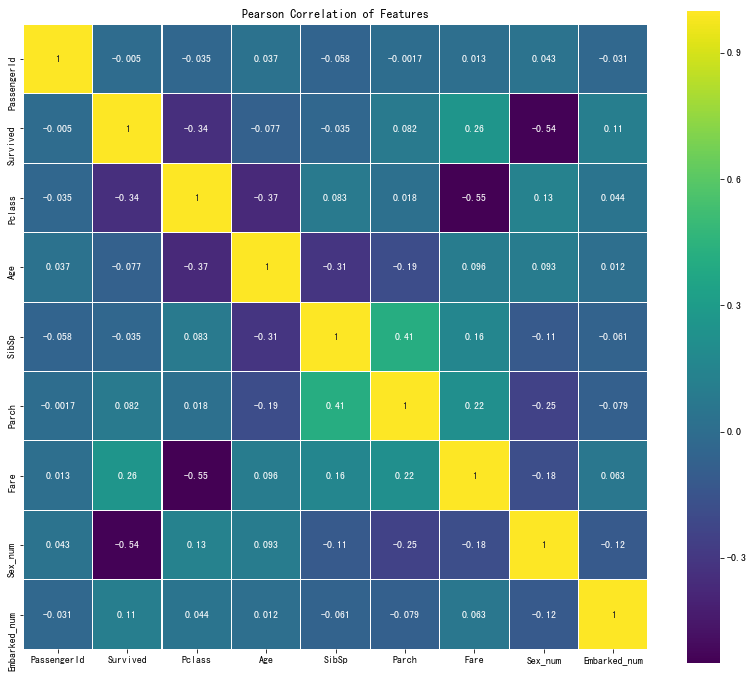

In [132]:
colormap = plt.cm.viridis
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features')
sns.heatmap(raw_data_num.corr(), linewidths=0.1, vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

#### EAD小结

1. 可能会对预测结果有重要影响的特征：Age（低龄段）、Sex、Pclass、Embarked（C段）和Fare
2. Cabin缺失最为严重，Age有100+的缺失，Embarked有2例缺失
3. 潜在的预处理方案：（1）age分窗；（2）fare均值（除以cabin数）；（3）Cabin号段提取；（4）Name信息提取

### baseline模型

在不对原始数据进行深度处理和模型调参的基础上，采用的所有模型的准确率都在75%以上，其中最好的Adaboost，最差为svc。但模型的方差较大。

#### 删失数据

剔除Embarked缺失的案例，删除有缺失值的Cabin和Age特征。进行数据划分，设置简单模型，将其结果作为baseline

In [133]:
data = raw_data.dropna(subset=['Embarked'])
raw_data.dropna()
data = data.dropna(axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S


#### 特征简单处理

1. Embarked进行one-hot编码
2. Sex进行one-hot编码
3. 删除PassengerId字段以及Name、Ticket等文本字段

In [136]:
Embarked_onehot = pd.get_dummies(data['Embarked'],prefix="Embarked")
Sex_onehot = pd.get_dummies(data['Sex'],prefix="Sex")

In [138]:
data = pd.concat([data, Embarked_onehot, Sex_onehot], axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S,0,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S,0,0,1,0,1


In [140]:
data2 = data.copy(deep=True)
data2.drop(['PassengerId', 'Name','Sex','Ticket', 'Embarked'], axis=1, inplace=True)
data2.head()

,Survived,Pclass,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,0,3,1,0,7.2500,0,0,1,0,1
1,1,1,1,0,71.2833,1,0,0,1,0
2,1,3,0,0,7.9250,0,0,1,1,0
3,1,1,1,0,53.1000,0,0,1,1,0
4,0,3,0,0,8.0500,0,0,1,0,1


In [142]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
Survived      889 non-null int64
Pclass        889 non-null int64
SibSp         889 non-null int64
Parch         889 non-null int64
Fare          889 non-null float64
Embarked_C    889 non-null uint8
Embarked_Q    889 non-null uint8
Embarked_S    889 non-null uint8
Sex_female    889 non-null uint8
Sex_male      889 non-null uint8
dtypes: float64(1), int64(4), uint8(5)
memory usage: 46.0 KB


In [148]:
data2_X = data2.drop('Survived', axis=1)
data2_Y = data2['Survived']

In [149]:
data2_X.head()

,Pclass,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,3,1,0,7.2500,0,0,1,0,1
1,1,1,0,71.2833,1,0,0,1,0
2,3,0,0,7.9250,0,0,1,1,0
3,1,1,0,53.1000,0,0,1,1,0
4,3,0,0,8.0500,0,0,1,0,1


In [150]:
data2_Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

#### 基础模型

In [143]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xgb = XGBClassifier()
lr = LogisticRegression()
svc = SVC()

In [145]:
from sklearn.model_selection import cross_val_score

In [156]:
estimators = [dt, rf, gbc, xgb,lr, svc]
estimators_names = ['DecisionTree', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LogisticRegression', 'SVC']

In [158]:
results = []
for estimator in estimators:
    result = cross_val_score(estimator=estimator, X=data2_X, y=data2_Y, cv=5)
    results.append(result)
results = np.array(results)
results

array([[0.74157303, 0.79213483, 0.83146067, 0.78651685, 0.81920904],
       [0.76404494, 0.75280899, 0.8258427 , 0.81460674, 0.81355932],
       [0.7752809 , 0.78089888, 0.86516854, 0.7752809 , 0.81355932],
       [0.7752809 , 0.78651685, 0.85393258, 0.78089888, 0.80225989],
       [0.7752809 , 0.79775281, 0.7752809 , 0.7752809 , 0.8079096 ],
       [0.73595506, 0.71910112, 0.79213483, 0.76966292, 0.77966102]])

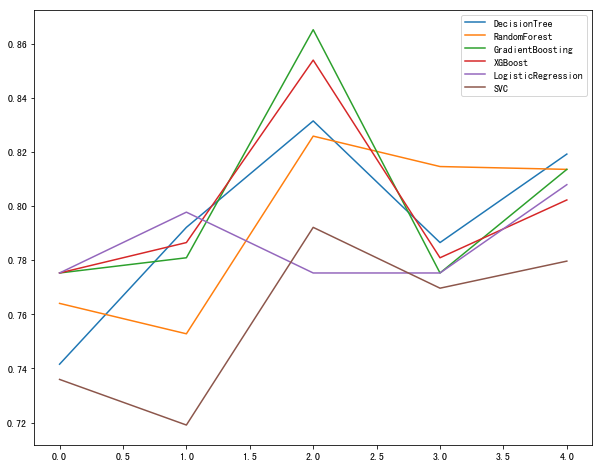

In [160]:
fig = plt.figure(figsize=(10, 8))
for i, estimator in enumerate(estimators_names):
    plt.plot(results[i, :], label=estimator)
plt.legend()
plt.show()

In [174]:
estimators_dict = {i: j.mean() for i,j in zip(estimators_names, results)}
sorted(estimators_dict.items(), key=lambda x:x[1], reverse=True)

[('GradientBoosting', 0.8020377071034088),
 ('XGBoost', 0.7997778200977591),
 ('DecisionTree', 0.79417888656129),
 ('RandomForest', 0.794172538564083),
 ('LogisticRegression', 0.7863010220275501),
 ('SVC', 0.7593029899066844)]

### 观察下测试集的特征

通过观察，测试数据集的整体分布和训练集相当，因此

In [207]:
raw_data_test = pd.read_csv('./test.csv')

In [209]:
import pandas_profiling
report4test = pandas_profiling.ProfileReport(raw_data_test)
report4test.to_file('./eda4test.html')

In [231]:
raw_data.fillna(raw_data.groupby('Pclass').transform(np.mean))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,25.14062,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00000,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00000,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00000,1,0,237736,30.0708,NaN,C
